# ANN assisted TPS on capped alanine dipeptide 2
In this notebook you will learn
- how to perform input importance analyses for models with transformed atomistic coordinates, i.e. how to find which are the important ANN inputs and how to relate them to atomistic coordinates
- how to create visualizizations of the transitions colored by gradient

This notebook uses files created in `1_setup_and_TPS.ipynb`, please do this notebook first.

In [1]:
%matplotlib inline

In [2]:
import os
import arcd
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 9, 6  # make the figures a bit bigger
import openpathsampling as paths

Using TensorFlow backend.


In [3]:
# change to the working directory of choice
# same as for the first notebook
wdir = '/homeloc/scratch/hejung/arcd_scratch/ala/'
#wdir = None
if wdir is not None:
    os.chdir(wdir)

In [4]:
storage = paths.Storage('ala_HB_TPS.nc', 'a')

In [5]:
# get the sampler, attach the hook and run for 1 step to repopulate the trainset and load the model
sampler = storage.pathsimulators[0]
sampler.restart_at_step(storage.steps[-1], storage=storage)

trainhook = arcd.ops.TrainingHook(None, None, 100)
sampler.attach_hook(trainhook)

sampler.run(1)

Working on Monte Carlo cycle number 2004
Starting simulation...
Working on first step


/homeloc/scratch/hejung/conda-envs/arcd_devel/lib/python3.6/site-packages/mdtraj/utils/validation.py:116: TypeCastPerformanceWarning: Casting unitcell_vectors dtype=float64 to <class 'numpy.float32'> 
  TypeCastPerformanceWarning)


DONE! Completed 2004 Monte Carlo cycles.


In [6]:
# lets make a movie
gmovie = arcd.analysis.GradientMovieMaker(trainhook.model, trainhook.model.descriptor_transform, storage.snapshots[-1].topology.mdtraj)

In [7]:
tras = []
for step in storage.steps[-50:]:
    if step.change.canonical.accepted:
        tras.append(step.change.canonical.trials[0].trajectory)

In [8]:
[len(t) for t in tras]

[36, 61, 45, 41, 35, 26, 153, 59, 47, 48, 38]

In [6]:
top = storage.snapshots[-1].topology.mdtraj

In [7]:
ats = top.select('not resname HOH')

In [8]:
ats

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

In [12]:
gmovie.color_by_gradient(tras[0], 'ala_movie_0.pdb', atom_indices=ats)

In [13]:
gmovie.color_by_gradient(tras[1], 'ala_movie_1.pdb', atom_indices=ats)

In [14]:
gmovie.color_by_gradient(tras[2], 'ala_movie_2.pdb', atom_indices=ats)

## HIPR analysis
We will have a look at the most important inputs and which atoms contribute to them.

In [9]:
hipr = arcd.analysis.HIPRanalysis(trainhook.model, trainhook.trainset)

In [10]:
final_hipr_losses = hipr.do_hipr()

In [11]:
final_hipr_losses_plus = hipr.do_hipr_plus()

In [12]:
# lets load the model after 100 MCsteps to compare
from arcd.base.rcmodel import RCModel
fname = storage.abspath + '_RCmodel_at_step500.pckl'
state, cls = RCModel.load_state(fname, storage)
state = cls.fix_state(state)
model_at_step500 = cls.set_state(state)

In [13]:
# use the complete trainset for HIPR
# this includes point the ANN has never trained on but makes it comparable to the previous HIPR
hipr_at_step500 = arcd.analysis.HIPRanalysis(model_at_step500, trainhook.trainset)

In [14]:
step500_hipr_losses = hipr_at_step500.do_hipr()
step500_hipr_losses_plus = hipr_at_step500.do_hipr_plus()

Reference loss:  1.1595420456694034
coordinate:  ('cos', [4, 6, 8, 14])
with associated loss:  1.1829425035122625
coordinate:  ('sin', [4, 6, 8, 14])
with associated loss:  1.1783793588360387
coordinate:  ('sin', [8, 14, 16, 18])
with associated loss:  1.1752259991126146
coordinate:  ('cos', [1, 4, 6, 8])
with associated loss:  1.1669859385538006
coordinate:  [4, 6, 8]
with associated loss:  1.1631893652879788


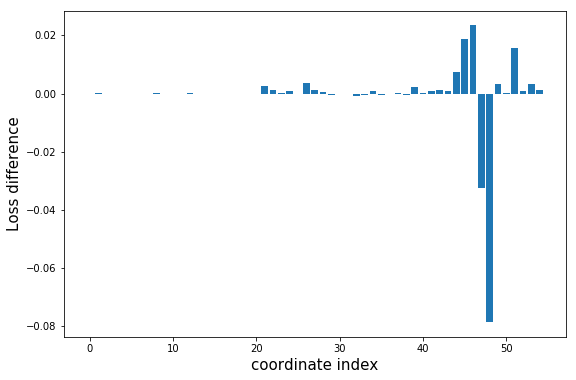

In [15]:
final_loss_diff = final_hipr_losses[:-1] - final_hipr_losses[-1]
step500_loss_diff = step500_hipr_losses[:-1] - step500_hipr_losses[-1]

plt.bar(np.arange(len(final_loss_diff)), final_loss_diff)
plt.xlabel('coordinate index', size=15)
plt.ylabel('Loss difference', size=15)

# get the associated coordinates for the maximally important input
max_idx = np.argsort(final_loss_diff)[::-1]

# this bit below only works for IC only
# figuring out how to get the info for SF CVs is left as an excersise to the reader :)
ic_parms = trainhook.model.descriptor_transform.kwargs['ic_parms']


print('Reference loss: ', final_hipr_losses[-1])
for idx in max_idx[:5]:
    # this little helper function gets you the involved atoms given the input index and the inputparameters to the CV of question
    # there is similar functions for the symmetry functions @ arcd.coords.symmetry.get_involved
    print('coordinate: ', arcd.coords.internal.get_involved(idx, **ic_parms))
    print('with associated loss: ', final_hipr_losses[idx])

Reference loss:  1.1594646210204103
coordinate:  ('cos', [4, 6, 8, 14])
with associated loss:  1.1723522833483424
coordinate:  ('sin', [6, 8, 10, 11])
with associated loss:  1.170436317002226
coordinate:  ('cos', [14, 16, 18, 19])
with associated loss:  1.167758867031562
coordinate:  ('cos', [1, 4, 6, 8])
with associated loss:  1.1665373568049449
coordinate:  ('sin', [4, 6, 8, 14])
with associated loss:  1.165656200568833


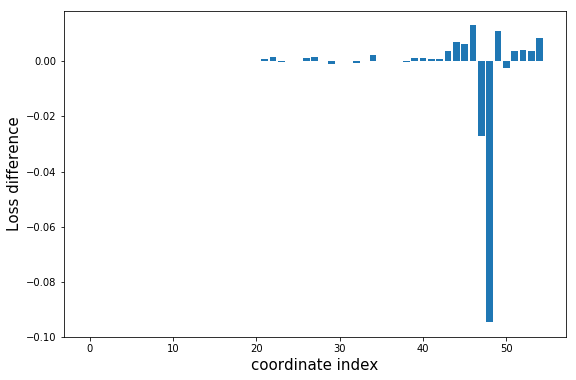

In [16]:
plt.bar(np.arange(len(step500_loss_diff)), step500_loss_diff, label='after step 100')
plt.xlabel('coordinate index', size=15)
plt.ylabel('Loss difference', size=15)

max_idx = np.argsort(step500_loss_diff)[::-1]
print('Reference loss: ', step500_hipr_losses[-1])
for idx in max_idx[:5]:
    print('coordinate: ', arcd.coords.internal.get_involved(idx, **ic_parms))
    print('with associated loss: ', step500_hipr_losses[idx])

Reference loss:  1.1595420456694034
coordinate:  ('cos', [4, 6, 8, 14])
with associated loss:  1.1785950841542014
coordinate:  ('sin', [8, 14, 16, 18])
with associated loss:  1.1706666242100758
coordinate:  ('sin', [4, 6, 8, 14])
with associated loss:  1.1631915429395117
coordinate:  ('sin', [14, 16, 18, 19])
with associated loss:  1.1631273798837871
coordinate:  [4, 6, 8]
with associated loss:  1.1626102561722258


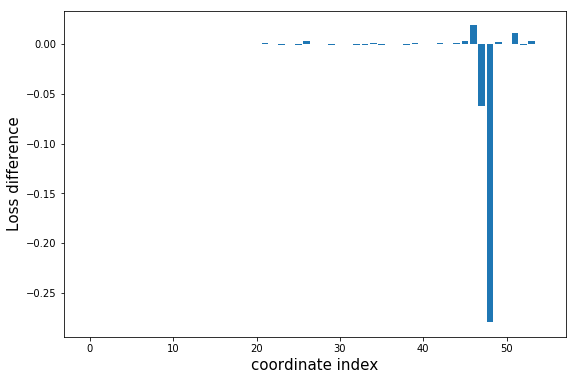

In [17]:
final_loss_diff_plus = final_hipr_losses_plus[:-1] - final_hipr_losses_plus[-1]
step500_loss_diff_plus = step500_hipr_losses_plus[:-1] - step500_hipr_losses_plus[-1]

plt.bar(np.arange(len(final_loss_diff_plus)), final_loss_diff_plus)
plt.xlabel('coordinate index', size=15)
plt.ylabel('Loss difference', size=15)

# get the associated coordinates for the maximally important input
max_idx = np.argsort(final_loss_diff_plus)[::-1]

# this bit below only works for IC only
# figuring out how to get the info for SF CVs is left as an excersise to the reader :)
ic_parms = trainhook.model.descriptor_transform.kwargs['ic_parms']


print('Reference loss: ', final_hipr_losses_plus[-1])
for idx in max_idx[:5]:
    # this little helper function gets you the involved atoms given the input index and the inputparameters to the CV of question
    # there is similar functions for the symmetry functions @ arcd.coords.symmetry.get_involved
    print('coordinate: ', arcd.coords.internal.get_involved(idx, **ic_parms))
    print('with associated loss: ', final_hipr_losses_plus[idx])

In [40]:
trainset = trainhook.trainset
model = trainhook.model
n_redraw = 1

In [43]:
from arcd.base.trainset import TrainSet

In [47]:
# last entry is for true loss
hipr_losses = np.zeros((trainset.descriptors.shape[1] + 1,))
maxes = np.max(trainset.descriptors, axis=0)
mins = np.min(trainset.descriptors, axis=0)
for _ in range(n_redraw):
            for i in [48]:
                descriptors = trainset.descriptors.copy()
                descriptors[:, i] = ((maxes[i] - mins[i])
                                     * np.random.ranf(size=len(trainset))
                                     + mins[i]
                                     )
                ts = TrainSet(
                       trainset.states,
                       descriptor_transform=trainset.descriptor_transform,
                       descriptors=descriptors,
                       shot_results=trainset.shot_results
                              )
                hipr_losses[i] += model.test_loss(ts)
# take the mean
hipr_losses /= n_redraw
# and add reference loss
hipr_losses[-1] = model.test_loss(trainset)


In [51]:
p_true = model(trainset.descriptors, use_transform=False)
p_false = model(ts.descriptors, use_transform=False)

(array([127., 153., 198., 251., 288., 240., 221., 184., 173., 169.]),
 array([0.03336942, 0.12624075, 0.21911207, 0.31198338, 0.4048547 ,
        0.49772602, 0.59059733, 0.68346864, 0.77634   , 0.8692113 ,
        0.9620826 ], dtype=float32),
 <a list of 10 Patch objects>)

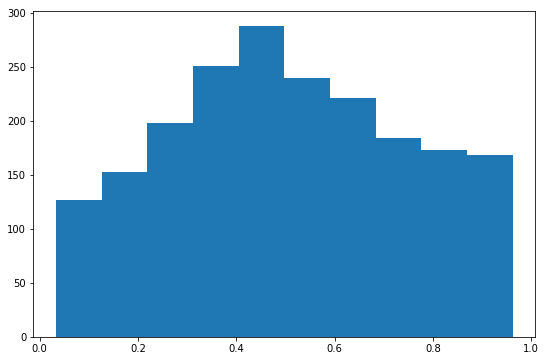

In [52]:
plt.hist(p_true)

(array([191., 223., 145., 134.,  96., 104., 131., 142., 266., 572.]),
 array([0.04630766, 0.13970007, 0.23309249, 0.3264849 , 0.4198773 ,
        0.5132697 , 0.6066621 , 0.7000545 , 0.79344696, 0.88683933,
        0.98023176], dtype=float32),
 <a list of 10 Patch objects>)

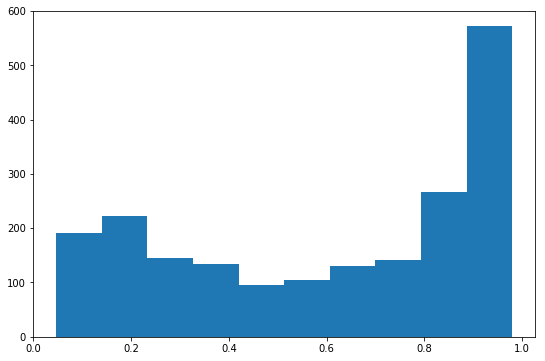

In [54]:
plt.hist(p_false)

In [63]:
print(np.max(p_true), np.max(p_false))

0.9620826 0.98023176


In [64]:
print(np.min(p_true), np.min(p_false))

0.033369422 0.04630766


In [65]:
np.sum(trainset.shot_results[:, 0])

2013.0

In [66]:
np.sum(trainset.shot_results[:, 1])

1995.0

In [69]:
len(np.where(trainset.shot_results[:, 1] == 2)[0])

610

In [70]:
len(np.where(trainset.shot_results[:, 0] == 2)[0])

619

In [73]:
np.log(0.046)

-3.079113882493042

In [18]:
trainhook.model.test_loss(trainhook.trainset)

1.1595420456694034

In [19]:
final_loss_diff[48]

-0.07853393859254143

In [20]:
arcd.coords.internal.get_involved(48, **ic_parms)

('cos', [6, 8, 14, 15])

(array([ 14.,  59.,  91., 115., 204., 377., 490., 384., 174.,  96.]),
 array([0.12094837, 0.20795841, 0.29496844, 0.38197847, 0.4689885 ,
        0.55599853, 0.64300857, 0.7300186 , 0.81702863, 0.90403866,
        0.99104869]),
 <a list of 10 Patch objects>)

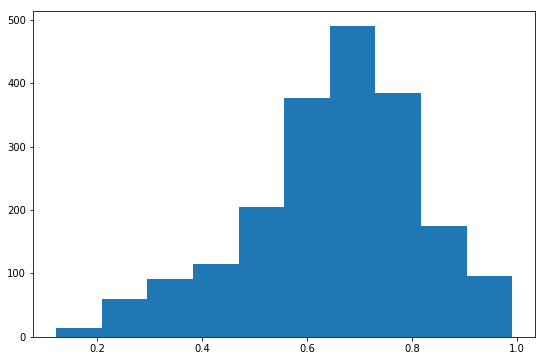

In [21]:
plt.hist(trainhook.trainset.descriptors[:, 48])

## Now we know that the dihedral between atoms 14, 16, 18 and 19 seems to be quite important....so what are these atoms?

In [23]:
# lets get a snapshot from trajectory, such that we can ask its topology object for the atom names
snap = storage.snapshots[-1]
topol = snap.topology.mdtraj

In [24]:
for at in [4, 6, 8, 14, 16, 18, 19]:
    print('atom: ', topol.atom(at), ' with index: ', at)

atom:  ACE1-C  with index:  4
atom:  ALA2-N  with index:  6
atom:  ALA2-CA  with index:  8
atom:  ALA2-C  with index:  14
atom:  NME3-N  with index:  16
atom:  NME3-C  with index:  18
atom:  NME3-H1  with index:  19


In [17]:
model_at_step100.test_loss(trainhook.trainset)

0.6966980620697661

In [18]:
trainhook.model.test_loss(trainhook.trainset)

1.3725112625411697

In [16]:
trainhook.trainset.descriptors.copy()

array([[1.09000117e-01, 1.54878810e-01, 1.08999938e-01, ...,
        4.91410494e-04, 2.35554904e-01, 7.56548643e-02],
       [1.08999930e-01, 1.52039677e-01, 1.08999878e-01, ...,
        5.24520874e-06, 8.12097907e-01, 8.90634000e-01],
       [1.09000124e-01, 1.49299413e-01, 1.09000020e-01, ...,
        1.92236602e-02, 6.53135598e-01, 2.40278542e-02],
       ...,
       [1.08999893e-01, 1.50930539e-01, 1.09000519e-01, ...,
        9.95385647e-03, 2.74688005e-04, 5.16571343e-01],
       [1.09000050e-01, 1.52551562e-01, 1.08999990e-01, ...,
        2.64850557e-02, 4.91738319e-04, 4.77830261e-01],
       [1.09000027e-01, 1.48676485e-01, 1.09000415e-01, ...,
        2.66651511e-02, 9.90160167e-01, 4.01293337e-01]])

In [22]:
snap_idx = np.random.choice(len(storage.snapshots), size=30, replace=False)

In [24]:
C_7eq = storage.volumes.find('C_7eq')
alpha_R = storage.volumes.find('alpha_R')

In [25]:
snaps = [storage.snapshots[int(i)] for i in snap_idx if not (C_7eq(storage.snapshots[int(i)]) or (alpha_R(storage.snapshots[int(i)])))]

In [26]:
len(snaps)

30

In [27]:
committor_store = paths.Storage('ala_committor.nc', 'w', template=storage.snapshots[-1])

In [28]:
import openpathsampling.engines.openmm as peng_omm
import simtk.openmm as mm
import simtk.unit as unit
from simtk.openmm import app
from openmmtools.integrators import VVVRIntegrator


cur_dir = '/home/tb/hejung/Documents/sources/arcd/examples/capped_alanine_dipeptide/'


# ENgine
forcefield = app.ForceField('amber99sbildn.xml', 'tip3p.xml')
pdb = app.PDBFile(os.path.join(cur_dir, "AD_initial_frame.pdb"))
system = forcefield.createSystem(pdb.topology,
                                 nonbondedMethod=app.PME,
                                 nonbondedCutoff=1.0*unit.nanometers,
                                 constraints=app.HBonds,
                                 rigidWater=True,
                                 ewaldErrorTolerance=0.0005
                                 )
integrator = VVVRIntegrator(300*unit.kelvin,  # T
                            1.0/unit.picoseconds,  # fric
                            2.0*unit.femtoseconds)  # dt
integrator.setConstraintTolerance(0.00001)
engine_options = {
    'n_frames_max': 2000,
    'nsteps_per_frame': 10,
}
engine = peng_omm.Engine(storage.snapshots[-1].topology,
                         system,
                         integrator,
                         options=engine_options
                         )
engine.name = '300K'

In [29]:
# randomizer
beta = 1.0 / (engine.integrator.getTemperature() * unit.BOLTZMANN_CONSTANT_kB)
modifier = paths.RandomVelocities(beta=beta, engine=engine)

In [30]:
cSim = paths.CommittorSimulation(committor_store, engine=engine, states=[C_7eq, alpha_R], randomizer=modifier, initial_snapshots=snaps)

In [31]:
cSim.run(50)

Working on snapshot 30 / 30; shot 50 / 50

In [32]:
def hashfx(snap):
    for i, st in enumerate(snaps):
        if np.allclose(st.coordinates, snap.coordinates, rtol=1e-6, atol=1e-4):
            return i

In [81]:
spa = paths.ShootingPointAnalysis(None, states=[C_7eq, alpha_R])

In [82]:
spa.hash_function = hashfx

In [83]:
spa.analyze(committor_store.steps)

In [89]:
p_B = spa.committor(alpha_R, hashfx)

In [95]:
p_true = np.zeros(30)
for key, val in p_B.items():
    print(key, val)
    p_true[int(key)] = val

0 0.94
1 0.8
2 0.54
3 0.92
4 0.94
5 0.64
6 0.9
7 1.0
8 0.34
9 0.94
10 0.08
11 0.92
12 0.48
13 0.52
14 0.94
15 0.0
16 0.92
17 0.54
18 0.92
19 0.92
20 0.84
21 0.74
22 0.94
23 0.02
24 0.56
25 0.9
26 0.96
27 0.04
28 0.44
29 0.86


In [93]:
model(snaps[0])[0,0]

0.7917024

In [94]:
p_predicted = [model(s)[0, 0] for s in snaps]

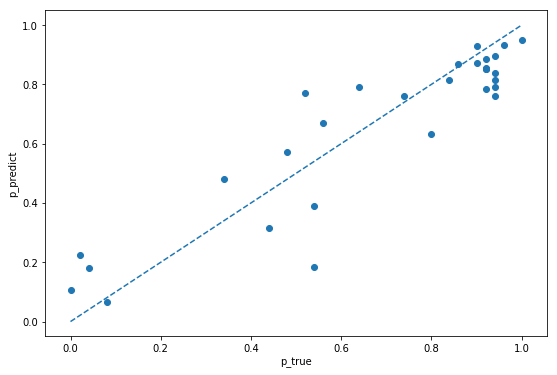

In [97]:
plt.scatter(p_true, p_predicted)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), '--')
plt.xlabel('p_true')
plt.ylabel('p_predict')
plt.savefig('committor_test_ala_pytorch.pdf')